# ****California Housing Prices (a linear regression and a XGboost)****

## Table of Contents:
* [1-Preprocessing the data](#preprocessing)
* [2-Linear Regression](#Regression)
    * [2.1-Training the model](#Training)
    * [2.2-Evaluating the model](#Evaluation)
* [3-XGBoost](#Xgboost)
    * [3.1-Training the model](#Training2)
    * [3.2-Evaluating the model](#Evaluation2)
* [4-XGBoost vs Linear Regression](#Comparison)

## Preprocessing the data <a class="anchor" id="preprocessing"></a>

In [0]:
#importing the libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#loading the dataset and obtaining info about columns
df=pd.read_csv("housing.csv")
list(df)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [4]:
#description of the numerical columns
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
#count the values of the columns
df.count()

longitude             20640
latitude              20640
housing_median_age    20640
total_rooms           20640
total_bedrooms        20433
population            20640
households            20640
median_income         20640
median_house_value    20640
ocean_proximity       20640
dtype: int64

In [0]:
#We have missing values in the column total_bedrooms. We can drop the null rows or replace the null value for the mean.
#I choose to replace it with the mean
df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)


In [7]:
#I want information about the column "ocean_proximity"
df['ocean_proximity'].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [0]:
#Transform the variable into a numerical one.
def map_age(age):
    if age == '<1H OCEAN':
        return 0
    elif age == 'INLAND':
        return 1
    elif age == 'NEAR OCEAN':
        return 2
    elif age == 'NEAR BAY':
        return 3
    elif age == 'ISLAND':
        return 4
df['ocean_proximity'] = df['ocean_proximity'].apply(map_age)

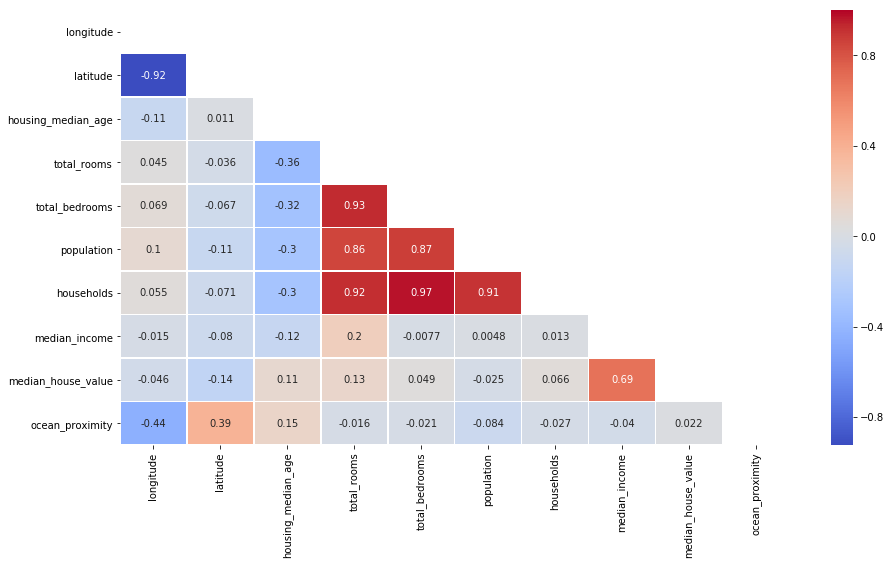

In [9]:
#Obtaining info of the correlations with a heatmap
plt.figure(figsize=(15,8))
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), linewidths=.5,annot=True,mask=mask,cmap='coolwarm')


In [0]:
#There is a high correlation between households and populati
df.drop('households', axis=1, inplace=True)


In [0]:
# let's create 2 more columns with the total bedrooms and rooms per population in the same block.
df['average_rooms']=df['total_rooms']/df['population']
df['average_bedrooms']=df['total_bedrooms']/df['population']


In [0]:
#dropping the 2 columns we are not going to use
df.drop('total_rooms',axis=1,inplace=True)
df.drop('total_bedrooms',axis=1,inplace=True)

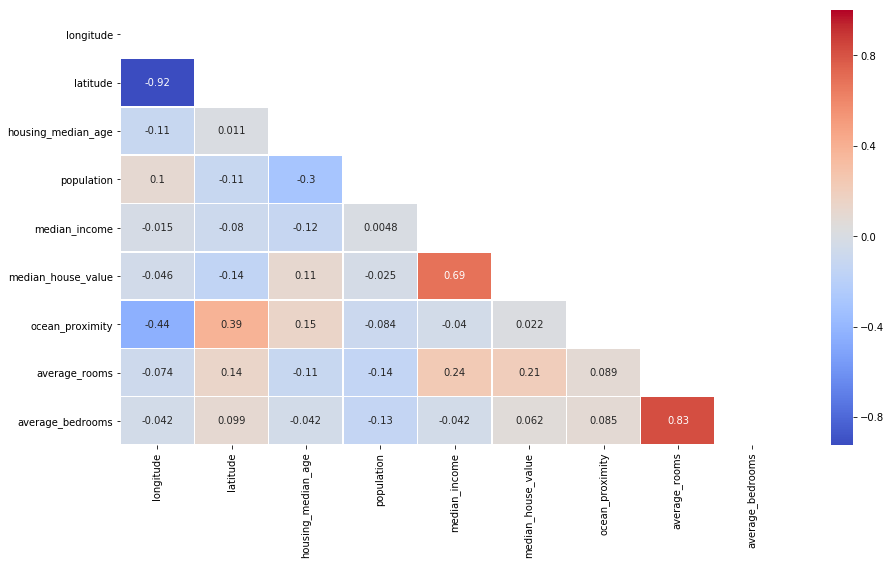

In [13]:
#Obtaining info of the new correlations with a heatmap
plt.figure(figsize=(15,8))
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), linewidths=.5,annot=True,mask=mask,cmap='coolwarm')

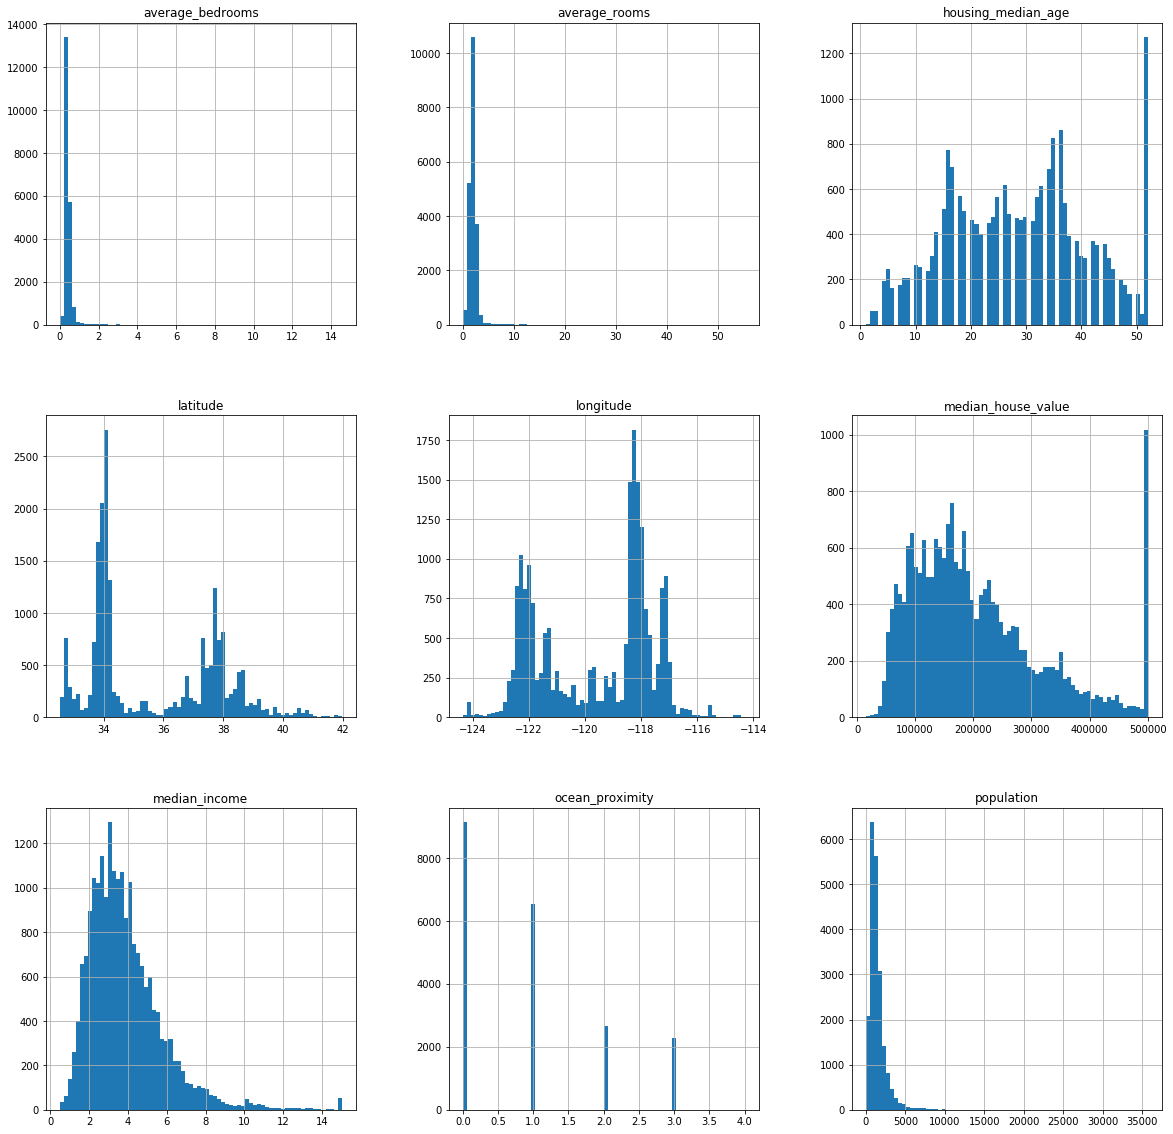

In [14]:
#histogram to get the distributions of the different variables
df.hist(bins=70, figsize=(20,20))
plt.show()

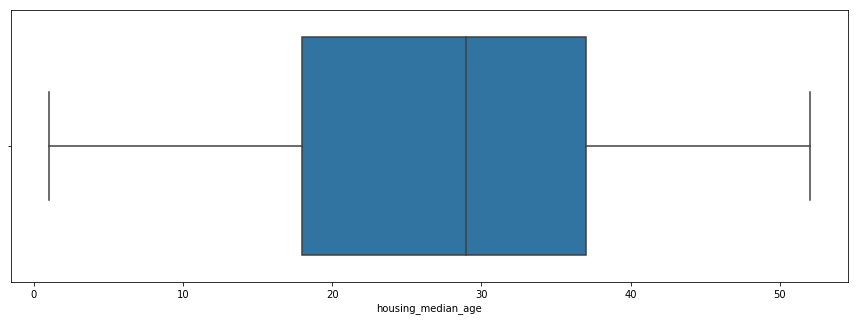

<Figure size 432x288 with 0 Axes>

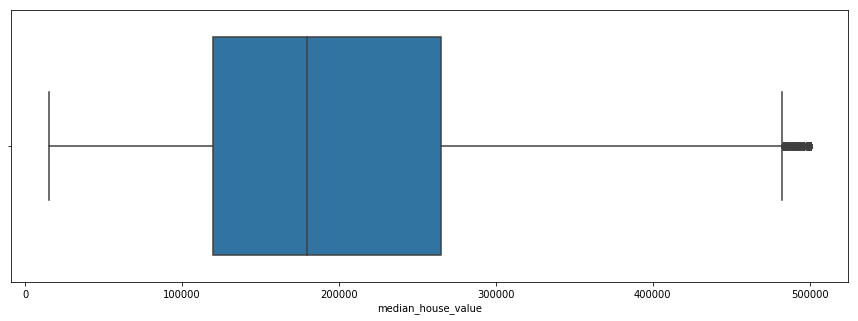

In [15]:
#Finding Outliers
plt.figure(figsize=(15,5))
sns.boxplot(x=df['housing_median_age'])
plt.figure()
plt.figure(figsize=(15,5))
sns.boxplot(x=df['median_house_value'])

In [0]:
#removing outliers
df=df.loc[df['median_house_value']<500001,:]

# Linear Regression <a class="anchor" id="Regression"></a>

## Training the model <a class="anchor" id="Training"></a>

In [0]:
#Choosing the dependant variable and the regressors. In this case we want to predict the housing price
X=df[['longitude',
 'latitude',
 'housing_median_age',
 'population',
 'median_income',
 'ocean_proximity',
 'average_rooms',
 'average_bedrooms']]
Y=df['median_house_value']

In [0]:
#splitting the dataset into the train set and the test set

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2, random_state=0)

In [19]:
#Training the model
from sklearn.linear_model import LinearRegression
regressor= LinearRegression()
regressor.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
#Obtaining the predictions
y_pred = regressor.predict(X_test)


## Evaluating the model <a class="anchor" id="Evaluation"></a>

In [21]:
#R2 score
from sklearn.metrics import r2_score
r2=r2_score(Y_test,y_pred)
print('the R squared of the linear regression is:', r2)

the R squared of the linear regression is: 0.5526714001645354


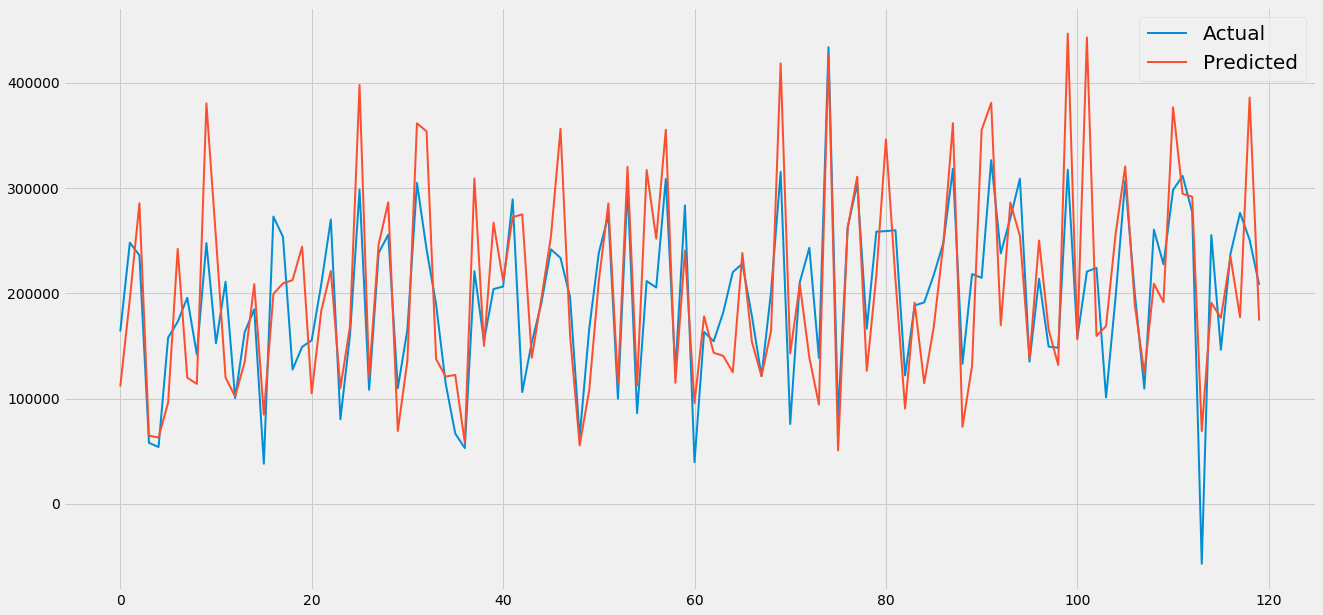

In [22]:
#Graphically
grp = pd.DataFrame({'prediction':y_pred,'Actual':Y_test})
grp = grp.reset_index()
grp = grp.drop(['index'],axis=1)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.plot(grp[:120],linewidth=2)
plt.legend(['Actual','Predicted'],prop={'size': 20})

# XGBoost <a class="anchor" id="Xgboost"></a>

## Training the model <a class="anchor" id="Training2"></a>

In [0]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1,eta=0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 2000)

In [24]:
xg_reg.fit(X_train,Y_train)

y_pred2 = xg_reg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:40:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Evaluating the model <a class="anchor" id="Evaluation2"></a>

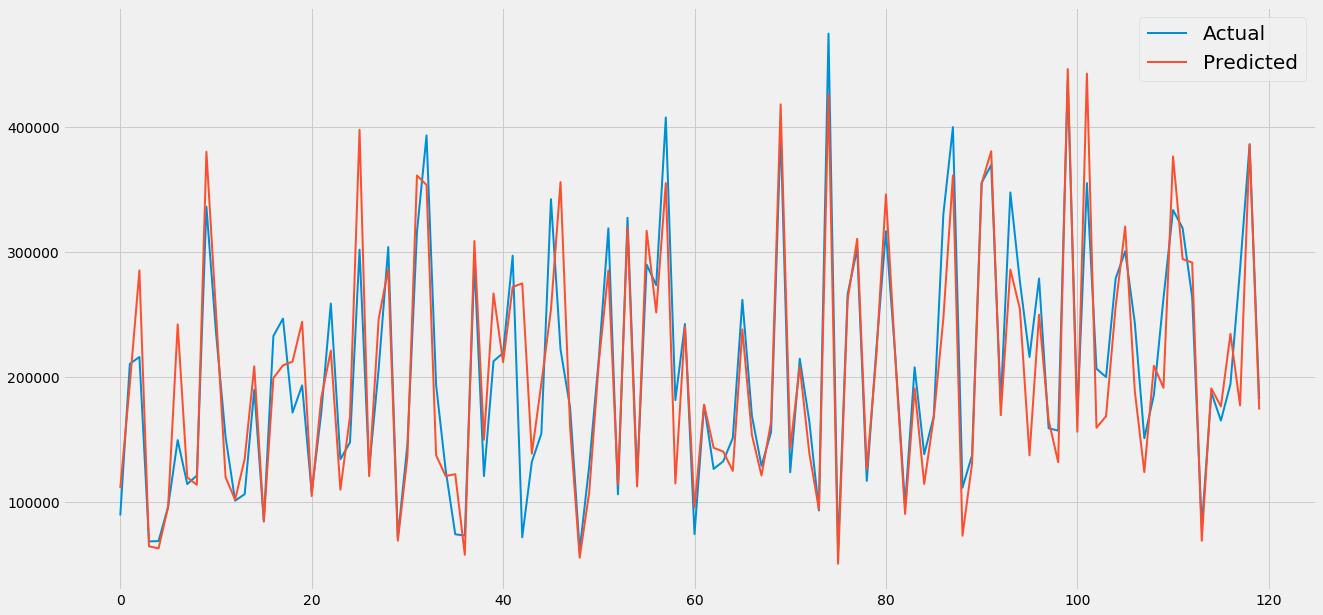

In [25]:
#Graphically
grp = pd.DataFrame({'prediction':y_pred2,'Actual':Y_test})
grp = grp.reset_index()
grp = grp.drop(['index'],axis=1)
plt.figure(figsize=(20,10))
plt.plot(grp[:120],linewidth=2)
plt.legend(['Actual','Predicted'],prop={'size': 20})

In [31]:
r2xgb=r2_score(Y_test,y_pred2)
print('the R squared of the xgboost method is:', r2xgb)

the R squared of the xgboost method is: 0.8227763364288538


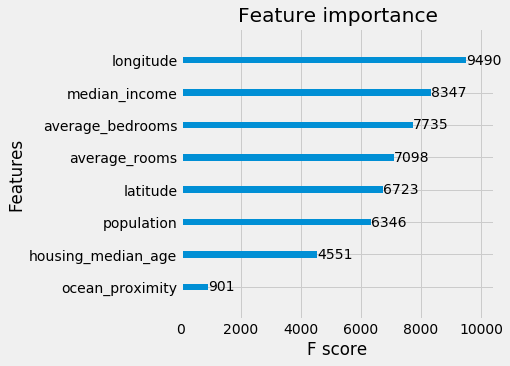

In [32]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [33]:
#Doing cross validation to see the accuracy of the XGboost model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(regressor, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 43.75% (10.12%)


# Linear regression vs XGBoost <a class="anchor" id="Comparison"></a>

In [34]:
#comparing the scores of both techniques 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

mae1 = mean_absolute_error(Y_test, y_pred)
rms1 = sqrt(mean_squared_error(Y_test, y_pred))
mae2 =mean_absolute_error(Y_test,y_pred2)
rms2 = sqrt(mean_squared_error(Y_test, y_pred2))

print('Stats for the linea regression: \n','mean squared error: ',rms1, '\n R2:',r2,' \n mean absolute error:',mae1 )
print('Stats xgboost: \n','mean squared error: ',rms2, '\n R2:',r2xgb,' \n mean absolute error:',mae2 )

Stats for the linea regression: 
 mean squared error:  65524.097680759114 
 R2: 0.5526714001645354  
 mean absolute error: 47427.6636381318
Stats xgboost: 
 mean squared error:  41242.84075742074 
 R2: 0.8227763364288538  
 mean absolute error: 27488.045577549237
